In [1]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [2]:
from datetime import date
import gc

In [3]:
my_data = './data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [4]:
fat_ljs_atual

,cod_loja,ano,mes,categoria,qtde,receita
0,1,2016,1,CATEG_01,301.0,9164.86
1,1,2016,2,CATEG_01,187.0,8175.55
2,1,2016,3,CATEG_01,242.0,10521.67
3,1,2016,4,CATEG_01,104.0,4560.91
4,1,2016,5,CATEG_01,100.0,4263.30
...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60
1003090,3687,2017,9,CATEG_14,33.0,62.70
1003091,3687,2017,10,CATEG_14,184.0,349.60
1003092,3687,2017,11,CATEG_14,28.0,61.30


In [5]:
recs_2016 = fat_ljs_atual[fat_ljs_atual.ano == 2016].groupby('cod_loja', as_index=False).sum()
recs_2017 = fat_ljs_atual[fat_ljs_atual.ano == 2017].groupby('cod_loja', as_index=False).sum()
recs_2016 = recs_2016.drop(columns=['qtde', 'mes'])
recs_2017 = recs_2017.drop(columns=['qtde', 'mes'])
recs_ano = recs_2016.merge(recs_2017, on='cod_loja', how='left')
recs_ano = recs_ano.drop(columns=['ano_x', 'ano_y'])
recs_ano = recs_ano.rename(columns={'receita_x':'receita_16', 'receita_y':'receita_17'})
recs_ano[recs_ano.receita_17 / recs_ano.receita_16 > 1.25]

,cod_loja,receita_16,receita_17
173,196,747922.38,939885.22
184,212,671981.94,968669.82
304,361,570693.38,985834.35
1147,1340,741017.66,931772.29
1150,1343,1226151.77,1649395.76
...,...,...,...
3017,3604,605199.18,1310715.82
3018,3606,696472.25,1423320.07
3019,3607,511651.93,1065107.95
3021,3610,90081.52,962059.64


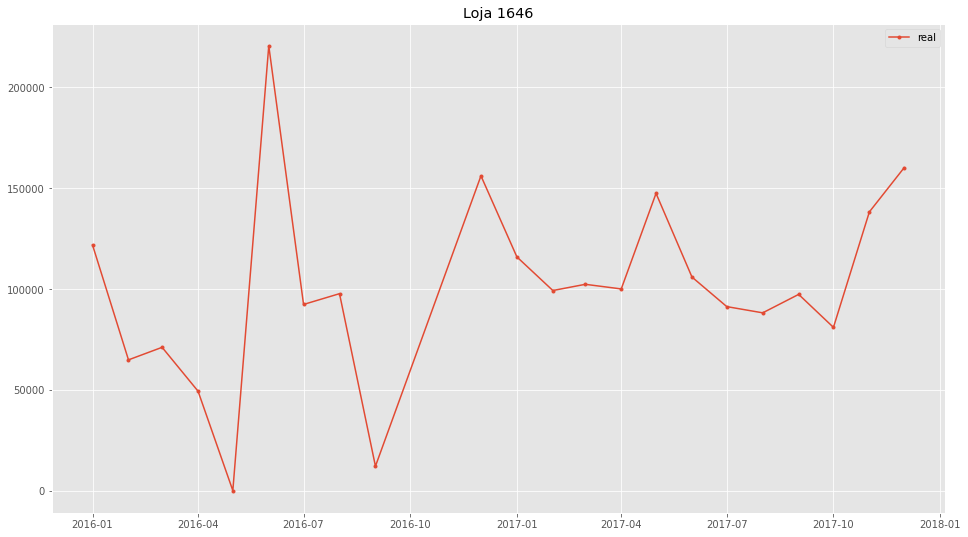

In [51]:
ids = 1646
fat_ljs_atual["datetime"] = pd.to_datetime(fat_ljs_atual.ano*100 + fat_ljs_atual.mes, format='%Y%m')
loja = fat_ljs_atual[fat_ljs_atual.cod_loja == ids][['datetime', 'receita']].groupby(['datetime'], as_index=False).sum()

plt.figure(figsize=(16,9))
plt.title("Loja {}".format(ids))
plt.plot(loja["datetime"], loja["receita"], label="real", marker=".")
plt.legend()
plt.show()

In [93]:
fer = pd.read_excel(my_data + "feriados.xlsx")
ibge = pd.read_excel(my_data + "ibge.xls")

In [94]:
ibge.head()

,UF,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município
0,11,Rondônia,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste
1,11,Rondônia,2,Leste Rondoniense,6,Cacoal,379,1100379,Alto Alegre dos Parecis
2,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,403,1100403,Alto Paraíso
3,11,Rondônia,2,Leste Rondoniense,5,Alvorada D'Oeste,346,1100346,Alvorada D'Oeste
4,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes


In [95]:
fer.rename(columns={'Tipo\n(E=Estadual,\nM=Municipal,\nN=Nacional)': 'Tipo'}, inplace=True)
fer.drop(columns=['Estado', 'Dia'], inplace=True)

In [96]:
estado_dict = {'SP':'São Paulo',
              'RS': 'Rio Grande do Sul',
              'PR': 'Paraná',
              'SC': 'Santa Catarina',
              'RJ': 'Rio de Janeiro',
              'AC': 'Acre',
              'AM': 'Amazonas',
              'AL': 'Alagoas',
              'SE': 'Sergipe',
              'MT': 'Mato Grosso',
              'TO': 'Tocantins',
              'PI': 'Piauí',
              'AP': 'Amapá',
              'MG': 'Minas Gerais',
              'RO': 'Rondônia',
              'PB': 'Paraíba',
              'CE': 'Ceará',
              'DF': 'Distrito Federal',
              'PE': 'Pernambuco',
              'MA': 'Maranhão',
              'ES': 'Espírito Santo',
              'PA': 'Pará',
              'RR': 'Roraima',
              'MS': 'Mato Grosso do Sul',
              'BA': 'Bahia',
              'RN': 'Rio Grande do Norte',
              'GO': 'Goiás'}
inv_est = {v: k for k, v in estado_dict.items()}

ibge['Sigla_UF'] = ibge.Nome_UF.apply(lambda x: inv_est[x])

In [97]:
fer

,Tipo,Sigla Estado,Código IBGE\ndo Município,Município,Mês,Observação
0,N,NaN,NaN,NaN,1,Confraternização Universal
1,N,NaN,NaN,NaN,5,Dia do Trabalhador
2,N,NaN,NaN,NaN,11,Finados
3,N,NaN,NaN,NaN,9,Independência
4,N,NaN,NaN,NaN,10,Nossa Senhora Aparecida
...,...,...,...,...,...,...
4894,M,SP,57204.0,CHAVANTES,7,NaN
4895,M,SP,57204.0,CHAVANTES,11,NaN
4896,M,SP,57303.0,ESTIVA GERBI,7,NaN
4897,M,SP,57303.0,ESTIVA GERBI,3,NaN


In [98]:
ibge

,UF,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município,Sigla_UF
0,11,Rondônia,2,Leste Rondoniense,6,Cacoal,15,1100015,Alta Floresta D'Oeste,RO
1,11,Rondônia,2,Leste Rondoniense,6,Cacoal,379,1100379,Alto Alegre dos Parecis,RO
2,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,403,1100403,Alto Paraíso,RO
3,11,Rondônia,2,Leste Rondoniense,5,Alvorada D'Oeste,346,1100346,Alvorada D'Oeste,RO
4,11,Rondônia,2,Leste Rondoniense,3,Ariquemes,23,1100023,Ariquemes,RO
...,...,...,...,...,...,...,...,...,...,...
5565,52,Goiás,5,Sul Goiano,16,Pires do Rio,22005,5222005,Vianópolis,GO
5566,52,Goiás,5,Sul Goiano,15,Meia Ponte,22054,5222054,Vicentinópolis,GO
5567,52,Goiás,4,Leste Goiano,12,Entorno de Brasília,22203,5222203,Vila Boa,GO
5568,52,Goiás,4,Leste Goiano,12,Entorno de Brasília,22302,5222302,Vila Propício,GO


In [99]:
fer = fer.rename(columns={'Tipo\n(E=Estadual,\nM=Municipal,\nN=Nacional)': 'Tipo'})
n = nacionais = fer[fer.Tipo == 'N']
n = n.groupby('Mês').size().to_frame('count').reset_index()
estaduais = fer[fer.Tipo == 'E']
e = estaduais.groupby(['Mês', 'Sigla Estado']).size().to_frame('count').reset_index()

In [100]:
municipais = fer[fer.Tipo == 'M']
municipais.dropna(subset=['Código IBGE\ndo Município'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
municipais['cod_municipio'] = municipais['Código IBGE\ndo Município'].astype('int')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [102]:
m = municipais.groupby(['Mês', 'cod_municipio']).size().to_frame('count').reset_index()

In [115]:
m

,Mês,cod_municipio,count
0,1,100,1
1,1,101,1
2,1,159,1
3,1,209,1
4,1,407,1
...,...,...,...
4136,12,55208,1
4137,12,55802,1
4138,12,56354,1
4139,12,57006,1


In [121]:
lja = ljs_atual.merge(ibge[['Código Município Completo', 'Sigla_UF']], left_on='cod_municipio', right_on='Código Município Completo', how='left')

In [124]:
fat_com_cod_uf = fat_ljs_atual.merge(lja[['cod_loja', 'cod_municipio', 'Sigla_UF']], on='cod_loja')

In [129]:
fat_com_cod_uf['cnt_feriados'] = 0

In [134]:
n_dict = n.Mês.value_counts().to_dict()
fat_com_cod_uf['cnt_feriados'] = 

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [140]:
rel = fat_com_cod_uf[['cod_loja', 'cod_municipio', 'Sigla_UF', 'mes', 'cnt_feriados']]

In [153]:
rel = rel.merge(n, left_on=['mes'], right_on=['Mês'], how='left')
rel = rel.merge(e, left_on=['mes', 'Sigla_UF'], right_on=['Mês', 'Sigla Estado'], how='left')
rel = rel.merge(m, left_on=['mes', 'cod_municipio'], right_on=['Mês', 'cod_municipio'], how='left')

In [165]:
rel.cnt_feriados = rel.count_x + rel.count_y + rel['count']

In [169]:
final = rel[['cod_loja', 'mes', 'cnt_feriados']]
final.to_csv(my_data + 'feriados.csv')